# Example Model Explanations with Seldon
Seldon core supports various out-of-the-box explainers that leverage the [Alibi ML Expalinability](https://github.com/SeldonIO/alibi) open source library.

In this notebook we show how you can use the pre-packaged explainer functionality that simplifies the creation of advanced AI model explainers.

Seldon provides the following out-of-the-box pre-packaged explainers:
* Anchor Tabular Explainer 
    * AI Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for tabular data
    * It basically answers the question of what are the most "powerul" or "important" features in a tabular prediction
* Anchor Image Explainer
    * AI Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for image data
    * It basically answers the question of what are the most "powerul" or "important" pixels in an image prediction
* Anchor Text Explainer
    * AI Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for text data
    * It basically answers the question of what are the most "powerul" or "important" tokens in a text prediction
* Counterfactual Explainer
    * AI Explainer that uses the [counterfactual technique](https://docs.seldon.io/projects/alibi/en/latest/methods/CF.html) for any type of data
    * It basically provides insight of what are the minimum changes you can do to an input to change the prediction to a different class
* Contrastive Explainer
    * AI explainer that uses the [Contrastive Explanations](https://docs.seldon.io/projects/alibi/en/latest/methods/CEM.html) technique for any type of data
    * It basically provides insights of what are the minimum changes you can do to an input to change the prediction to change the prediction or the minimum components of the input to make it the same prediction

## Running this notebook

For the [ImageNet Model](#Imagenet-Model) you will need:

 - [alibi package](https://pypi.org/project/alibi/) (```pip install alibi```)
 
 This should install the required package dependencies, if not please also install:
 - [Pillow package](https://pypi.org/project/Pillow/) (```pip install Pillow```)
 - [matplotlib package](https://pypi.org/project/matplotlib/) (```pip install matplotlib```)
 - [tensorflow package](https://pypi.org/project/tensorflow/) (```pip install tensorflow```)

You will also need to start Jupyter with settings to allow for large payloads, for example:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000
```

## Setup Seldon Core

Follow the instructions to [Setup Cluster](seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](seldon_core_setup.ipynb#Install-Seldon-Core).

 Then port-forward to that ingress on localhost:8003 in a separate terminal either with:

 * Ambassador: `kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080`
 * Istio: `kubectl port-forward $(kubectl get pods -l istio=ingressgateway -n istio-system -o jsonpath='{.items[0].metadata.name}') -n istio-system 8003:80`

### Create Namespace for experimentation

We will first set up the namespace of Seldon where we will be deploying all our models

In [ ]:
!kubectl create namespace seldon

And then we will set the current workspace to use the seldon namespace so all our commands are run there by default (instead of running everything in the default namespace.)

In [ ]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

## Income Prediction Model with Anchors Explainer

In [ ]:
%%writefile resources/income_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: income
spec:
  name: income
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/income/model-0.23.2
      name: classifier
    explainer:
      type: AnchorTabular
      modelUri: gs://seldon-models/sklearn/income/explainer-py36-0.5.2
    name: default
    replicas: 1

In [ ]:
!kubectl apply -f resources/income_explainer.yaml

In [ ]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=income -o jsonpath='{.items[0].metadata.name}')

In [ ]:
!kubectl rollout status deploy/income-default-explainer

In [ ]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="income",namespace="seldon", gateway="ambassador", gateway_endpoint="localhost:8003")

Use python client library to get a prediction.

In [ ]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
r = sc.predict(data=data)
print(r.response)

Use curl to get a prediction.

In [ ]:
!curl -d '{"data": {"ndarray":[[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]]}}' \
   -X POST http://localhost:8003/seldon/seldon/income/api/v1.0/predictions \
   -H "Content-Type: application/json"

Use python client library to get an explanation.

In [ ]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
explanation = sc.explain(deployment_name="income", predictor="default", data=data)
print(explanation.response["data"]["anchor"])

Using curl to get an explanation.

In [ ]:
!curl -X POST -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60, 9]]}}' \
    http://localhost:8003/seldon/seldon/income-explainer/default/api/v1.0/explain | jq ".data.anchor"

In [ ]:
!kubectl delete -f resources/income_explainer.yaml

## Movie Sentiment Model



In [ ]:
%%writefile resources/moviesentiment_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: movie
spec:
  name: movie
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/moviesentiment
      name: classifier
    explainer:
      type: AnchorText
    name: default
    replicas: 1

In [ ]:
!kubectl apply -f resources/moviesentiment_explainer.yaml

In [ ]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=movie -o jsonpath='{.items[0].metadata.name}')

In [ ]:
!kubectl rollout status deploy/movie-default-explainer

In [ ]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="movie", namespace="seldon", gateway_endpoint="localhost:8003", payload_type='ndarray')

In [ ]:
!curl -d '{"data": {"ndarray":["This film has great actors"]}}' \
   -X POST http://localhost:8003/seldon/seldon/movie/api/v1.0/predictions \
   -H "Content-Type: application/json"

In [ ]:
data = np.array(['this film has great actors'])
r = sc.predict(data=data)
print(r)
assert(r.success==True)

In [ ]:
!curl -s -d '{"data": {"ndarray":["a visually exquisite but narratively opaque and emotionally vapid experience of style and mystification"]}}' \
   -X POST http://localhost:8003/seldon/seldon/movie-explainer/default/api/v1.0/explain \
   -H "Content-Type: application/json" | jq ".data.anchor"

In [ ]:
data = np.array(['a visually exquisite but narratively opaque and emotionally vapid experience of style and mystification'])
explanation = sc.explain(predictor="default", data=data)
print(explanation.response["data"]["anchor"])

In [ ]:
!kubectl delete -f resources/moviesentiment_explainer.yaml

## Imagenet Model



In [ ]:
%%writefile resources/imagenet_explainer_grpc.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: image
spec:
  annotations:
    seldon.io/rest-timeout: "10000000"
    seldon.io/grpc-timeout: "10000000"
    seldon.io/grpc-max-message-size: "1000000000"
  name: image
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: docker.io/seldonio/imagenet-transformer:0.1
          name: transformer
    graph:
      name: transformer
      type: TRANSFORMER
      endpoint:
        type: GRPC
      children: 
      - implementation: TENSORFLOW_SERVER
        modelUri: gs://seldon-models/tfserving/imagenet/model
        name: classifier
        endpoint:
          type: GRPC
        parameters:
          - name: model_name
            type: STRING
            value: classifier
          - name: model_input
            type: STRING
            value: input_image
          - name: model_output
            type: STRING
            value: predictions/Softmax:0
    svcOrchSpec:
      resources:
        requests:
          memory: 10Gi
        limits:
          memory: 10Gi          
      env:
      - name: SELDON_LOG_LEVEL
        value: DEBUG
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/imagenet/explainer-py36-0.5.2
      config:
        batch_size: "100"
      endpoint:
        type: GRPC
    name: default
    replicas: 1

In [ ]:
!kubectl apply -f resources/imagenet_explainer_grpc.yaml

In [ ]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=image -o jsonpath='{.items[0].metadata.name}')

In [ ]:
!kubectl rollout status deploy/image-default-explainer

In [ ]:
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
import alibi
from alibi.datasets import fetch_imagenet
import numpy as np

def get_image_data():
    data = []
    image_shape = (299, 299, 3)
    target_size = image_shape[:2]
    image = Image.open("cat-raw.jpg").convert('RGB')
    image = np.expand_dims(image.resize(target_size), axis=0)
    data.append(image)
    data = np.concatenate(data, axis=0)
    return data

data = get_image_data()

In [ ]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(
    deployment_name="image",
    namespace="seldon",
    grpc_max_send_message_length= 27 * 1024 * 1024,
    grpc_max_receive_message_length= 27 * 1024 * 1024, 
    gateway="ambassador",
    transport="grpc",
    gateway_endpoint="localhost:8003",
    client_return_type='proto')

In [ ]:
import tensorflow as tf
data = get_image_data()
req = data[0:1]
r = sc.predict(data=req, payload_type='tftensor')

preds = tf.make_ndarray(r.response.data.tftensor)

label = decode_predictions(preds, top=1)
plt.title(label[0])
plt.imshow(data[0])

In [ ]:
req = np.expand_dims(data[0], axis=0)
r = sc.explain(data=req, predictor="default", transport="rest", payload_type='ndarray', client_return_type="dict")

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[0])
axarr[1].imshow(r.response["data"]["anchor"])
plt.show()


In [ ]:
!kubectl delete -f resources/imagenet_explainer_grpc.yaml

## Tensorflow CIFAR10 Model

In [ ]:
%%writefile resources/cifar10_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10-classifier
spec:
  protocol: tensorflow
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - componentSpecs:
    graph:
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: cifar10-classifier
      logger:
         mode: all
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/cifar10/explainer-py36-0.5.2
    name: default
    replicas: 1

In [ ]:
!kubectl apply -f resources/cifar10_explainer.yaml

In [ ]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10-classifier -o jsonpath='{.items[0].metadata.name}')

In [ ]:
!kubectl rollout status deploy/cifar10-classifier-default-explainer

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

url = 'https://storage.googleapis.com/seldon-models/alibi-detect/classifier/'
path_model = os.path.join(url, "cifar10", "resnet32", 'model.h5')
save_path = tf.keras.utils.get_file("resnet32", path_model)
model = tf.keras.models.load_model(save_path)

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from subprocess import run, Popen, PIPE
import json
import numpy as np
idx=12
test_example=X_test[idx:idx+1].tolist()
payload='{"instances":'+f"{test_example}"+' }'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10-classifier/v1/models/cifar10-classifier/:predict \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
print(raw)
res=json.loads(raw)
arr=np.array(res["predictions"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[arr[0].argmax()])

In [ ]:
test_example=X_test[idx:idx+1].tolist()
payload='{"instances":'+f"{test_example}"+' }'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10-classifier-explainer/default/v1/models/cifar10-classifier:explain \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
explanation = json.loads(raw)
arr = np.array(explanation["data"]["anchor"])
plt.imshow(arr)

In [ ]:
!kubectl delete -f resources/cifar10_explainer.yaml

## Wine Prediction Model with Shap Explainer

In [ ]:
import shap
shap.initjs()

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
wine = load_wine()
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
%%writefile resources/wine_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: wine
spec:
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/wine/model-py36-0.23.2
      name: classifier
      parameters:
        - name: method
          type: STRING
          value: decision_function       
    explainer:
      type: KernelShap
      modelUri: gs://seldon-models/sklearn/wine/kernel_shap_py36
    name: default
    replicas: 1

In [ ]:
!kubectl apply -f resources/wine_explainer.yaml

In [ ]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=wine -o jsonpath='{.items[0].metadata.name}')

In [ ]:
!kubectl rollout status deploy/wine-default-explainer

In [ ]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="wine",namespace="seldon", gateway="ambassador", gateway_endpoint="localhost:8003")

Use python client library to get a prediction.

In [ ]:
data = np.array([[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236,
       -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713,
       -2.06608025, -1.55017035, -0.86659858]])
r = sc.predict(data=data)
print(r.response)
class_idx = np.argmax(np.array(r.response["data"]["tensor"]["values"]))

Use curl to get a prediction.

In [ ]:
!curl -d '{"data": {"ndarray":[[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236, -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713, -2.06608025, -1.55017035, -0.86659858]]}}' \
   -X POST http://localhost:8003/seldon/seldon/wine/api/v1.0/predictions \
   -H "Content-Type: application/json"

Use python client library to get an explanation.

In [ ]:
import json
data = np.array([[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236,
       -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713,
       -2.06608025, -1.55017035, -0.86659858]])
explanation = sc.explain(deployment_name="wine", predictor="default", data=data)
explanation = explanation.response
expStr = json.dumps(explanation)

In [ ]:
from alibi.api.interfaces import Explanation
explanation = Explanation.from_json(expStr)

In [ ]:
explanation.shap_values = np.array(explanation.shap_values)
explanation.raw["instances"] = np.array(explanation.raw["instances"])

In [ ]:
idx=0
shap.force_plot(
    explanation.expected_value[class_idx], 
    explanation.shap_values[class_idx][idx, :], 
    explanation.raw['instances'][idx][None, :],  
    explanation.feature_names,
)

Using curl to get an explanation.

In [ ]:
!curl -X POST -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": [[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236, -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713, -2.06608025, -1.55017035, -0.86659858]]}}' \
    http://localhost:8003/seldon/seldon/wine-explainer/default/api/v1.0/explain | jq .

In [ ]:
!kubectl delete -f resources/wine_explainer.yaml

## MNIST Model with Integrated Gradients Explainer

In [167]:
%%writefile ../servers/tfserving/samples/mnist_rest.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: tfserving
spec:
  name: mnist
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/mnist-model
      name: mnist-model
      parameters:
        - name: signature_name
          type: STRING
          value: predict_images
        - name: model_name
          type: STRING
          value: mnist-model
    explainer:
      type: IntegratedGradients
      modelUri: gs://seldon-models/keras/mnist
    name: default
    replicas: 1

Overwriting ../servers/tfserving/samples/mnist_rest.yaml


In [168]:
!kubectl apply -f ../servers/tfserving/samples/mnist_rest.yaml

seldondeployment.machinelearning.seldon.io/tfserving created


In [169]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=tfserving -o jsonpath='{.items[0].metadata.name}')

deployment "tfserving-default-0-mnist-model" successfully rolled out


In [170]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [181]:
nb_samples = 10
X_test_sample = X_test[:nb_samples]
#predictions = model(X_test_sample).numpy().argmax(axis=1)

In [184]:
import json
d = {"data": {"tensor":{"shape":[10,784],"values":X_test_sample.flatten().tolist()}}}
with open("input.json","w") as f:
    f.write(json.dumps(d))

In [185]:
res=!curl -s -H 'Content-Type: application/json' \
    -d @./input.json \
    http://localhost:8003/seldon/seldon/tfserving/api/v1.0/predictions 
res=json.loads(res[0])

In [186]:
predictions = np.array(res["data"]["tensor"]["values"]).reshape(res["data"]["tensor"]["shape"])
predictions = predictions.argmax(axis=1)

In [187]:
predictions

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [188]:
import json
d = {"data": {"tensor":{"shape":X_test_sample.shape,"values":X_test_sample.flatten().tolist()}}}
with open("input.json","w") as f:
    f.write(json.dumps(d))

In [189]:
res=!curl -s -H 'Content-Type: application/json' \
    -d @./input.json \
    http://localhost:8003/seldon/seldon/tfserving-explainer/default/api/v1.0/explain
res=json.loads(res[0]) 

In [190]:
attrs = np.array(res["data"]["attributions"])

In [191]:
attrs.shape

(10, 28, 28, 1)

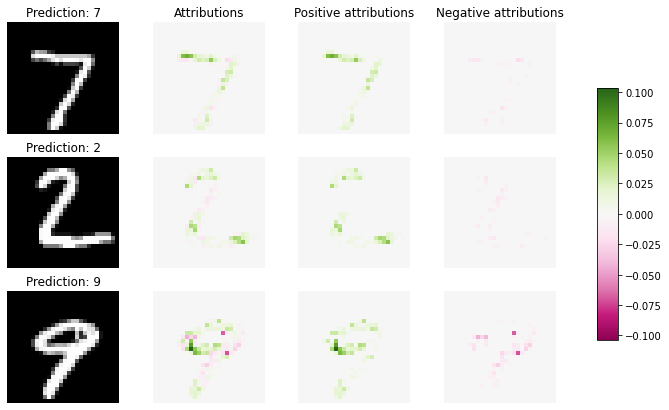

In [192]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[[0, 1, 9]]).max()

for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')
    
    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));